In [1]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint

from sheet_id.models.FCN import FCN
from sheet_id.utils.loss_functions import softmax_sparse_crossentropy_ignoring_background, softmax_sparse_crossentropy
from sheet_id.utils.metrics import sparse_accuracy_ignoring_background, sparse_accuracy
from sheet_id.utils.dataPreprocessing import splitTrainValidation
from sheet_id.utils.dataGenerator import DataGenerator
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

import matplotlib.pyplot as plt
import numpy as np

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Training

In [2]:
model = FCN(input_shape=(500,500,1), n_classes=124)

In [3]:
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = [sparse_accuracy]
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [4]:
callbacks = []

In [5]:
train_partition, validation_partition = splitTrainValidation('../data/', max_size=200, test_size=20, npy_only=True)

In [6]:
params = {'dim': (500,500),
          'batch_size': 1,
          'n_classes': 124,
          'n_channels': 1,
          'shuffle': True,
          'crop': True,
          'crop_size': (500,500),
          'load_npy': True}
training_generator = DataGenerator(train_partition, **params)
validation_generator = DataGenerator(validation_partition, **params)

In [ ]:
# history = model.fit_generator(generator=training_generator, epochs=10,
#                               validation_data=validation_generator,
#                               use_multiprocessing=True, workers=10,
#                               callbacks=callbacks,
#                               steps_per_epoch=10)

In [ ]:
# model.save_weights('../checkpoints/working_fcn.h5')

In [ ]:
# model.load_weights('../checkpoints/working_fcn.h5')

# Visualization

In [ ]:
# example_img, energy_map, class_map, bbox_map = training_generator[0]

In [ ]:
# model.evaluate(example_img, example_annotation)

In [ ]:
# prediction = model.predict(example_img)
# prediction = np.argmax(prediction, axis=-1)
# prediction.shape

In [ ]:
# img_id = 12
# plt.figure(figsize=(20,20))
# plt.subplot(1,3,1)
# plt.imshow(example_img[img_id,:,:,0], cmap='gray')
# plt.subplot(1,3,2)
# plt.imshow(example_annotation[img_id,:,:,0], cmap='gray', vmin=0, vmax=125)
# plt.title(np.unique(example_annotation[img_id,:,:,0]))
# plt.subplot(1,3,3)
# plt.imshow(prediction[img_id,:,:], cmap='gray', vmin=0, vmax=125)
# plt.title(np.unique(prediction))
# plt.show()

In [ ]:
# mask = 29
# masked = np.zeros_like(prediction[img_id, :, :])
# for row in range(prediction.shape[1]):
#     for col in range(prediction.shape[2]):
#         if prediction[img_id, row, col] == mask:
#             masked[row, col] = 255
#         else:
#             masked[row, col] = 0

# plt.imshow(masked, cmap='gray')
# plt.title('Prediction only for class {:}'.format(mask))
# plt.show()

# Deep Watershed

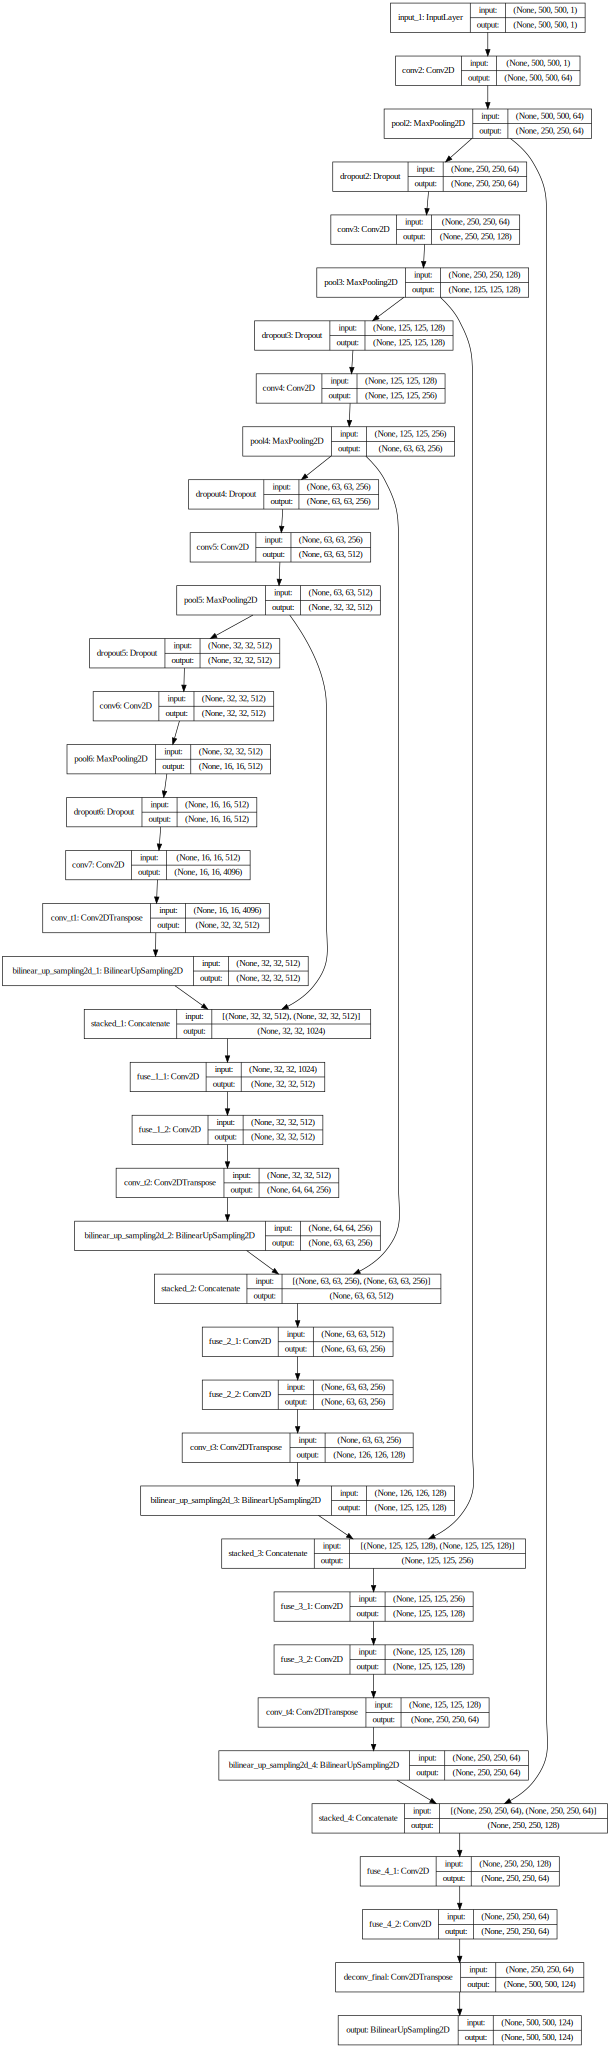

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model


SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
n_bins = 5
n_classes = 124

In [9]:
input_map = Input(shape=(500,500,1))
output_featuremaps = model(input_map)
energy_output = Conv2D(n_bins,    (1,1), activation='relu', padding='same', name='energy_map')(output_featuremaps)
class_output  = Conv2D(n_classes, (1,1), activation='relu', padding='same', name='class_map')(output_featuremaps)
bbox_output   = Conv2D(2,         (1,1), activation='relu', padding='same', name='bbox_map')(output_featuremaps)

In [27]:
dwd_model = Model(inputs=[input_map], outputs=[energy_output, class_output, bbox_output])
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = []
dwd_model.compile(loss={
                            "energy_map": loss_fn,
                            "class_map": loss_fn,
                            "bbox_map": "mse",
                        }, optimizer=optimizer, metrics=metrics)

In [55]:
dwd_model.fit_generator(generator=training_generator, epochs=10,
                              validation_data=validation_generator,
                              use_multiprocessing=True, workers=10,
                              callbacks=callbacks,
                              steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 7s 656ms/step - loss: 4.2942 - energy_map_loss: 0.0247 - class_map_loss: 0.0291 - bbox_map_loss: 4.2404 - val_loss: 6.2077 - val_energy_map_loss: 0.0275 - val_class_map_loss: 0.0333 - val_bbox_map_loss: 6.1469
Epoch 2/10
10/10 [==============================] - 6s 614ms/step - loss: 6.7934 - energy_map_loss: 0.0452 - class_map_loss: 0.0505 - bbox_map_loss: 6.6977 - val_loss: 7.6322 - val_energy_map_loss: 0.0322 - val_class_map_loss: 0.0366 - val_bbox_map_loss: 7.5634
Epoch 3/10
10/10 [==============================] - 6s 610ms/step - loss: 7.1134 - energy_map_loss: 0.0369 - class_map_loss: 0.0355 - bbox_map_loss: 7.0409 - val_loss: 9.0275 - val_energy_map_loss: 0.0315 - val_class_map_loss: 0.0395 - val_bbox_map_loss: 8.9565
Epoch 4/10
10/10 [==============================] - 6s 626ms/step - loss: 6.7942 - energy_map_loss: 0.0361 - class_map_loss: 0.0364 - bbox_map_loss: 6.7217 - val_loss: 5.3553 - val_energy_map_loss: 0.0305 - val_cla

In [75]:
X, y = validation_generator[0]

In [76]:
y_pred = dwd_model.predict(X)

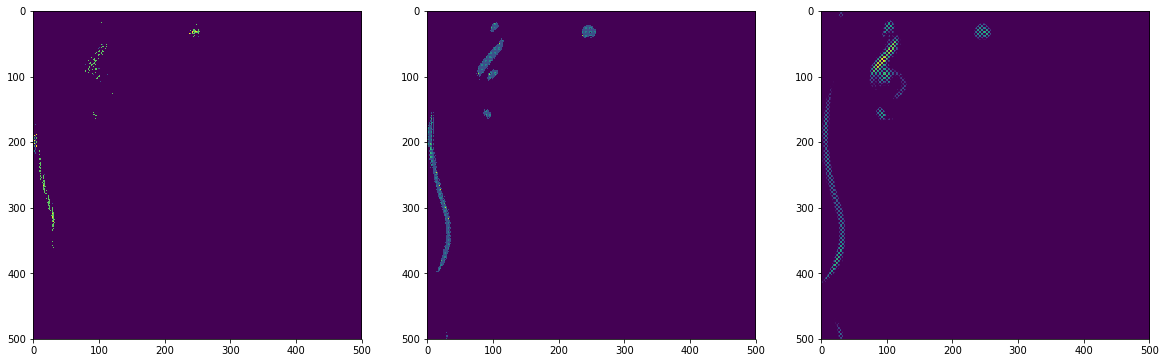

In [77]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(np.argmax(y_pred[0], axis=-1)[0])
plt.subplot(1,3,2)
plt.imshow(np.argmax(y_pred[1], axis=-1)[0])
plt.subplot(1,3,3)
plt.imshow(y_pred[2][0,:,:,0])

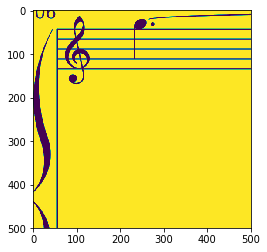

In [78]:
plt.imshow(X[0,:,:,0])

In [ ]:
# Array based union find data structure

# P: The array, which encodes the set membership of all the elements

class UFarray:
    def __init__(self):
        # Array which holds label -> set equivalences
        self.P = []

        # Name of the next label, when one is created
        self.label = 0

    def makeLabel(self):
        r = self.label
        self.label += 1
        self.P.append(r)
        return r
    
    # Makes all nodes "in the path of node i" point to root
    def setRoot(self, i, root):
        while self.P[i] < i:
            j = self.P[i]
            self.P[i] = root
            i = j
        self.P[i] = root

    # Finds the root node of the tree containing node i
    def findRoot(self, i):
        while self.P[i] < i:
            i = self.P[i]
        return i
    
    # Finds the root of the tree containing node i
    # Simultaneously compresses the tree
    def find(self, i):
        root = self.findRoot(i)
        self.setRoot(i, root)
        return root
    
    # Joins the two trees containing nodes i and j
    # Modified to be less agressive about compressing paths
    # because performance was suffering some from over-compression
    def union(self, i, j):
        if i != j:
            root = self.findRoot(i)
            rootj = self.findRoot(j)
            if root > rootj: root = rootj
            self.setRoot(j, root)
            self.setRoot(i, root)
    
    def flatten(self):
        for i in range(1, len(self.P)):
            self.P[i] = self.P[self.P[i]]
    
    def flattenL(self):
        k = 1
        for i in range(1, len(self.P)):
            if self.P[i] < i:
                self.P[i] = self.P[self.P[i]]
            else:
                self.P[i] = k
                k += 1

In [ ]:
def find_connected_comp(input):
    data = input
    width, height = input.shape

    # Union find data structure
    uf = UFarray()

    #
    # First pass
    #

    # Dictionary of point:label pairs
    labels = {}

    for y, x in product(range(height), range(width)):

        #
        # Pixel names were chosen as shown:
        #
        #   -------------
        #   | a | b | c |
        #   -------------
        #   | d | e |   |
        #   -------------
        #   |   |   |   |
        #   -------------
        #
        # The current pixel is e
        # a, b, c, and d are its neighbors of interest
        #
        # 255 is white, 0 is black
        # White pixels part of the background, so they are ignored
        # If a pixel lies outside the bounds of the image, it default to white
        #

        # If the current pixel is white, it's obviously not a component...
        if data[x, y] == 255:
            pass

        # If pixel b is in the image and black:
        #    a, d, and c are its neighbors, so they are all part of the same component
        #    Therefore, there is no reason to check their labels
        #    so simply assign b's label to e
        elif y > 0 and data[x, y - 1] == 0:
            labels[x, y] = labels[(x, y - 1)]

        # If pixel c is in the image and black:
        #    b is its neighbor, but a and d are not
        #    Therefore, we must check a and d's labels
        elif x + 1 < width and y > 0 and data[x + 1, y - 1] == 0:

            c = labels[(x + 1, y - 1)]
            labels[x, y] = c

            # If pixel a is in the image and black:
            #    Then a and c are connected through e
            #    Therefore, we must union their sets
            if x > 0 and data[x - 1, y - 1] == 0:
                a = labels[(x - 1, y - 1)]
                uf.union(c, a)

            # If pixel d is in the image and black:
            #    Then d and c are connected through e
            #    Therefore we must union their sets
            elif x > 0 and data[x - 1, y] == 0:
                d = labels[(x - 1, y)]
                uf.union(c, d)

        # If pixel a is in the image and black:
        #    We already know b and c are white
        #    d is a's neighbor, so they already have the same label
        #    So simply assign a's label to e
        elif x > 0 and y > 0 and data[x - 1, y - 1] == 0:
            labels[x, y] = labels[(x - 1, y - 1)]

        # If pixel d is in the image and black
        #    We already know a, b, and c are white
        #    so simpy assign d's label to e
        elif x > 0 and data[x - 1, y] == 0:
            labels[x, y] = labels[(x - 1, y)]

        # All the neighboring pixels are white,
        # Therefore the current pixel is a new component
        else:
            labels[x, y] = uf.makeLabel()

    print(len(labels))
    #
    # Second pass
    #

    uf.flatten()

    colors = {}

    # Image to display the components in a nice, colorful way
    output_img = Image.new("RGB", (width, height))
    outdata = output_img.load()

    for (x, y) in labels:

        # Name of the component the current point belongs to
        component = uf.find(labels[(x, y)])

        # Update the labels with correct information
        labels[(x, y)] = component

        # Associate a random color with this component
        if component not in colors:
            colors[component] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        # Colorize the image
        outdata[y, x] = colors[component]

    return (labels, output_img)

In [ ]:
prep = np.zeros_like(example_annotation[2,:,:,0])
for row in range(prep.shape[0]):
    for col in range(prep.shape[1]):
        if example_annotation[2,row,col,0] == 29:
            prep[row,col] = 0
        else:
            prep[row,col] = 255

In [ ]:
print(np.unique(example_annotation[2,:,:,0]))

In [ ]:
labels, out_img = find_connected_comp(prep)

In [ ]:
plt.imshow(out_img, cmap='gray')

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
from sheet_id.utils.base_utils import loadSettings, loadScoresDataset

In [ ]:
loadSettings()